## 1. Babynames analysis - A first look

[The United States Social Security Administration](href="https://www.ssa.gov/) has made available data on the frequency of baby names from 1880 through present. Despite the first impression, this a really interesting dataset which offers great opportunities for exploration and visualization.</p>
    <img src="https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcRxncVEtnFae2H1JzJ1KScJPtsHaEPjRu67VA&usqp=CAU" height="200" width="250">
    
The dataset is update once per year [here](http://www.ssa.gov/oact/babynames/limits.html). So to get us started we will import our data. If someone took a look to the dataset contained in the <em>dataset/babynames</em>, he or she would see that we have values values separated with comma, so our import is pretty straigthforward. So let's have a first look in our dataset!

In [1]:
import pandas as pd
from IPython import display

# Import data, print first rows
names1880 = pd.read_csv("./datasets/babynames/yob1880.txt")
names1880.head()

,Mary,F,7065
0,Anna,F,2604
1,Emma,F,2003
2,Elizabeth,F,1939
3,Minnie,F,1746
4,Margaret,F,1578


## 2.Managing Data per Years

Ok nothing surprising here, just our usuall, regular dataframe. Still, If we open the */babynames/* folder we will see that it contains a lot of txt folders,each containing tha list of baby names for the corresponding year. The next step is to import all the data and unify them into a single dataframe that will contain the `year` as an attribute.

In [2]:
# Prepare index and columns for unified dataframe
years = range(1880, 2011)
columns = ['name', 'sex', 'births']
pieces = []

# For each .txt create a frame, assign its 'year', keep them altogether in "piecies"
for year in years:
    path = './datasets/babynames/yob{:d}.txt'.format(year)
    frame = pd.read_csv(path,  names=columns)
    frame['year'] = year
    pieces.append(frame)
    
# Concat all "pieces" into a single dataframe
names = pd.concat(pieces, ignore_index=True)
names

,name,sex,births,year
0,Mary,F,7065,1880
1,Anna,F,2604,1880
2,Emma,F,2003,1880
3,Elizabeth,F,1939,1880
4,Minnie,F,1746,1880
...,...,...,...,...
1690779,Zymaire,M,5,2010
1690780,Zyonne,M,5,2010
1690781,Zyquarius,M,5,2010
1690782,Zyran,M,5,2010


## 3. Aggregating the data
So we have produced a quite large file (roughly 1 Million 7 hundred entries). The next step is to aggregate the data and since we are dealing with baby names naturally we are interesed in finding how the births, relative to each gender, distribute over the years. We are going to plot the result so

<AxesSubplot:title={'center':'Total births by sex and year'}, xlabel='year'>

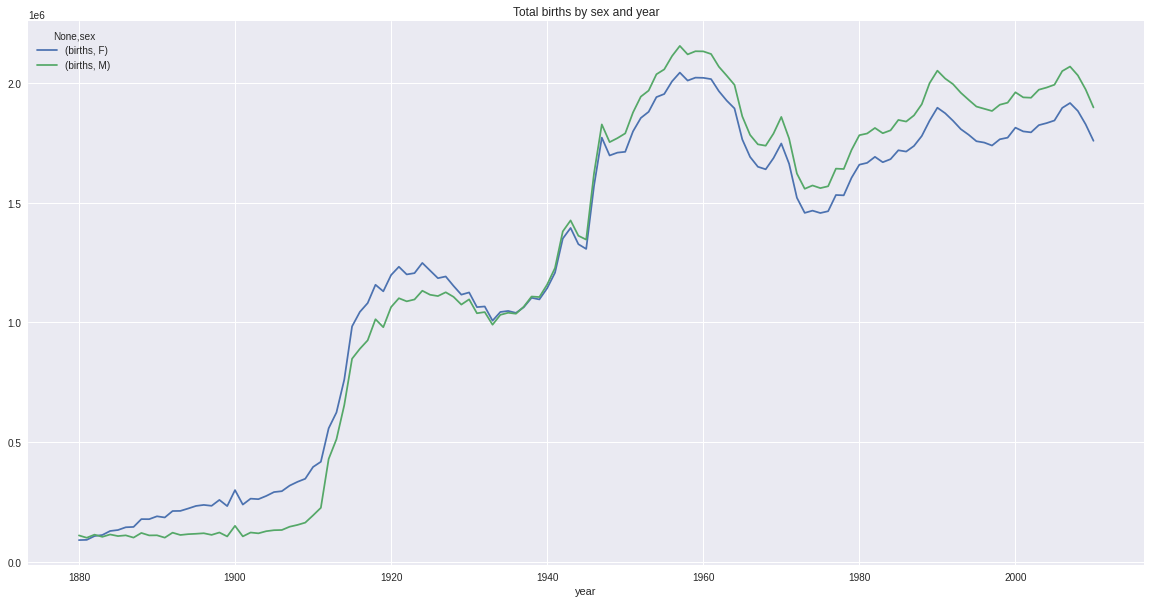

In [3]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# Create reshaped frame containg total births per gender, across the years
total_births = pd.pivot_table(data=names, index='year', columns='sex', aggfunc='sum')
total_births.tail()

# Plot births
total_births.plot(title="Total births by sex and year", figsize=(20,10))

## 4. Extracting Proportions of each name
Generally speaking we can see that we have a total incriment of births throughout the years, with some major "spikes" occuring during 1910-1920 and 1940-1960. We can also see some decreases, the reasons for these is a topic outside of the scope of this project but for example for the decrease in the 1920s one could presume that it happend due to the effects of the [*Great Recession*](https://en.wikipedia.org/wiki/Great_Recession).

---

Now we are going to find the proportion of each name by diving each element of <code>births</code> with the sum of births. This can be achieved by defining a function and applying it over our grouped frame

In [6]:
import numpy as np

# Calculate proportion and insert into the frame
def get_prop(group):
    group['proportion'] = group.births / group.births.sum()
    return group

# Group names by year and sex and apply "get_prop"
names = names.groupby(['year', 'sex']).apply(get_prop)


# Check if data is sanitized,each group prop summing up to 1
sanity_check = names.groupby(['year', 'sex']).proportion.sum()

# Round results avoiding numerical insignificant differences
def is_sanitized(frame):
    a = frame.to_numpy()
    return(1.0 == np.around(a , 8).all(0))


# Sanitization check and output printing
if is_sanitized(sanity_check):
    print("Results are properly sanitized:")
else:
    print("WARNING!!! Results are not properly sanitized:")

names


Results are properly sanitized:


,name,sex,births,year,proportion
0,Mary,F,7065,1880,0.077643
1,Anna,F,2604,1880,0.028618
2,Emma,F,2003,1880,0.022013
3,Elizabeth,F,1939,1880,0.021309
4,Minnie,F,1746,1880,0.019188
...,...,...,...,...,...
1690779,Zymaire,M,5,2010,0.000003
1690780,Zyonne,M,5,2010,0.000003
1690781,Zyquarius,M,5,2010,0.000003
1690782,Zyran,M,5,2010,0.000003


## 5. Names per gender
At first glimpse on our sanitized data we can see the predominance of some names for example "Mary" or "Ann" but we cannot specify if this is a trend that lasted throughout the years. Now we are to find the number of names for each gender. To do that firstly we are going to subset our data by extracting the top 1000 names and filter the one corresponding to each gender. After that we are to separate the entries referring to each gender.

In [5]:
# Function for getting first 1000 entries
def get_top1000(group):
    group_sorted = group.sort_values('births', ascending=False)
    return group_sorted[:1000]

# Group and print top1000
top1000 = names.groupby(['year', 'sex']).apply(get_top1000)
top1000.reset_index(inplace=True, drop=True)

# Subset for each gender
boys = top1000.loc[top1000['sex'].isin(['M'])]
girls = top1000.loc[top1000['sex'].isin(['F'])]

# Print number of names for each gender
print("The number of girl names are:", len(girls.index))
print("The number of boy names are:", len(boys.index))


The number of girl names are: 130880
The number of boy names are: 130997


## 6. Analyzing Naming Trends

We can see that number of names between girls and boy are roughly equal.  
Now let's pick up some names arbitrary and see how their corresponding number behave through out the years. Actually we have to deal with a time series (`year` on the x-axis and `births` on the y-axis) and as per usuall time series need a bit of munging to be useful. Here we are going to make a pivot table out of `top1000` that will contain the total number of births by year and sex and then we will make a visualization of the above.

array([<AxesSubplot:xlabel='year'>, <AxesSubplot:xlabel='year'>,
       <AxesSubplot:xlabel='year'>, <AxesSubplot:xlabel='year'>],
      dtype=object)

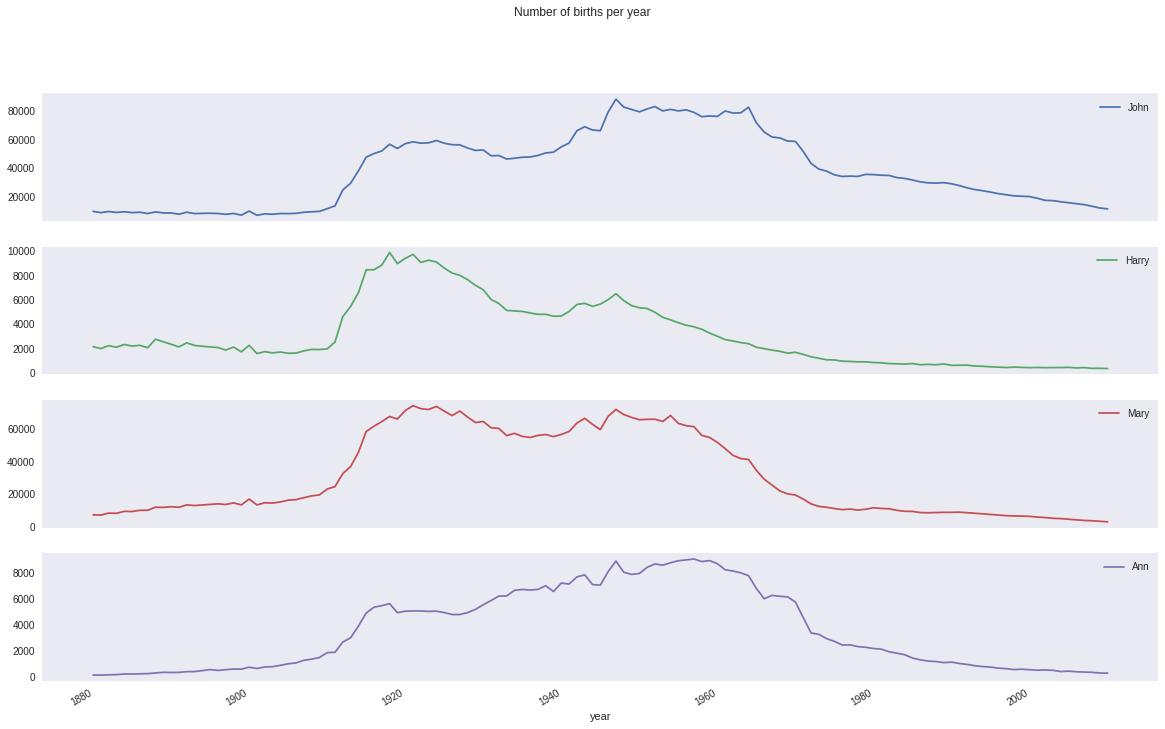

In [23]:
# Reshape 'top1000', aggregate entries
total_births = pd.pivot_table(top1000, values='births', index='year', columns='name', aggfunc=sum)

# Subset the names to be plotted
subset = total_births[['John', 'Harry', 'Mary', 'Ann']]
subset.plot(subplots=True, figsize=(20,12), grid=False, title="Number of births per year")

## 7. Measuring Name Diversity

The previous graph gives us a sense that in general their popularity decreased as the time goes by  however, as will we further see in our analysis, this is not exactly the case.

---

One explanation for the decreasing of popular names could be that fewer parents are choosing common names for their childern, a hypothesis that can be confirmed in the data by measuring the name diversity. We will measure this  in a rather "indirectl" way that is we will plot the proportions of births for the most popular names ( the `top100` frame) by year and sex. If the graph has a decreasing trend is indicator that the popular names are getting less popular which in turn means that the name diversity is rising.

<AxesSubplot:title={'center':'Proportion of births by year'}, xlabel='year'>

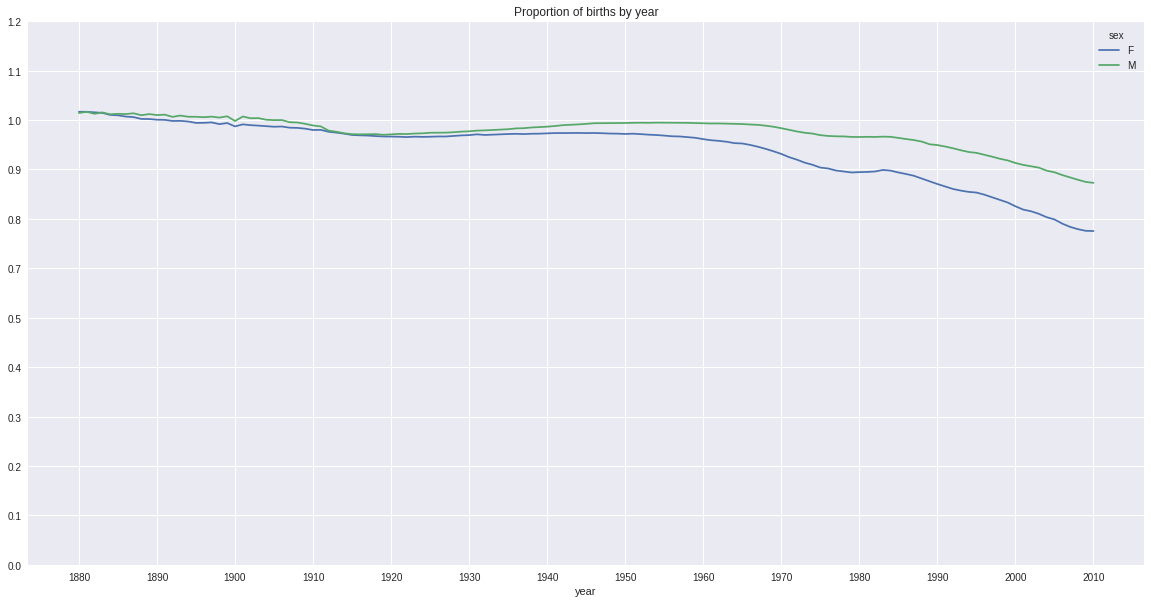

In [53]:
import matplotlib.pyplot as plt
%matplotlib inline

# yticks formatting: remove trailing zeroes, round on decimal
ax = plt.subplot(111)
tickFormat = FormatStrFormatter('%.1f')
ax.yaxis.set_major_formatter(tickFormat)

# Reshape and add up popular names by year and sex. Plot proportions.
pop_prop = top1000.pivot_table('proportion', index='year', columns='sex', aggfunc=sum)
pop_prop.plot(title="Proportion of births by year", figsize=(20,10),
              xticks=range(1880, 2020, 10), yticks=np.linspace(0, 1.2, 12), ax=ax)

